# SWE Changes in Anchorage, Alaska

In [1]:
import pandas as pd
import numpy as np
from scipy import stats 
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

### Introduction 
Snow packs act as frozen water towers, allowing the melt to run off. Storage and snow melt is an important part of the water budget and a critical resource for some areas. Knowing when to expect peak snow melt would be important as climate change effects are deepened making water resources sparse in some areas and overly abundant in others. 

### Specific research question: 
How has the snow water equivalent (SWE) peak changed in timing and magnitude in the hillside by Anchorage, Alaska? 

### Site Description

Anchorage is a city in the south-central region of Alaska, located on the coast of the Cook Inlet. It is the largest city in Alaska with a population of around 288,000 people in the metropolitan area. Anchorage serves as a hub for transportation, commerce, and culture in the state, and is surrounded by beautiful natural landscapes. 

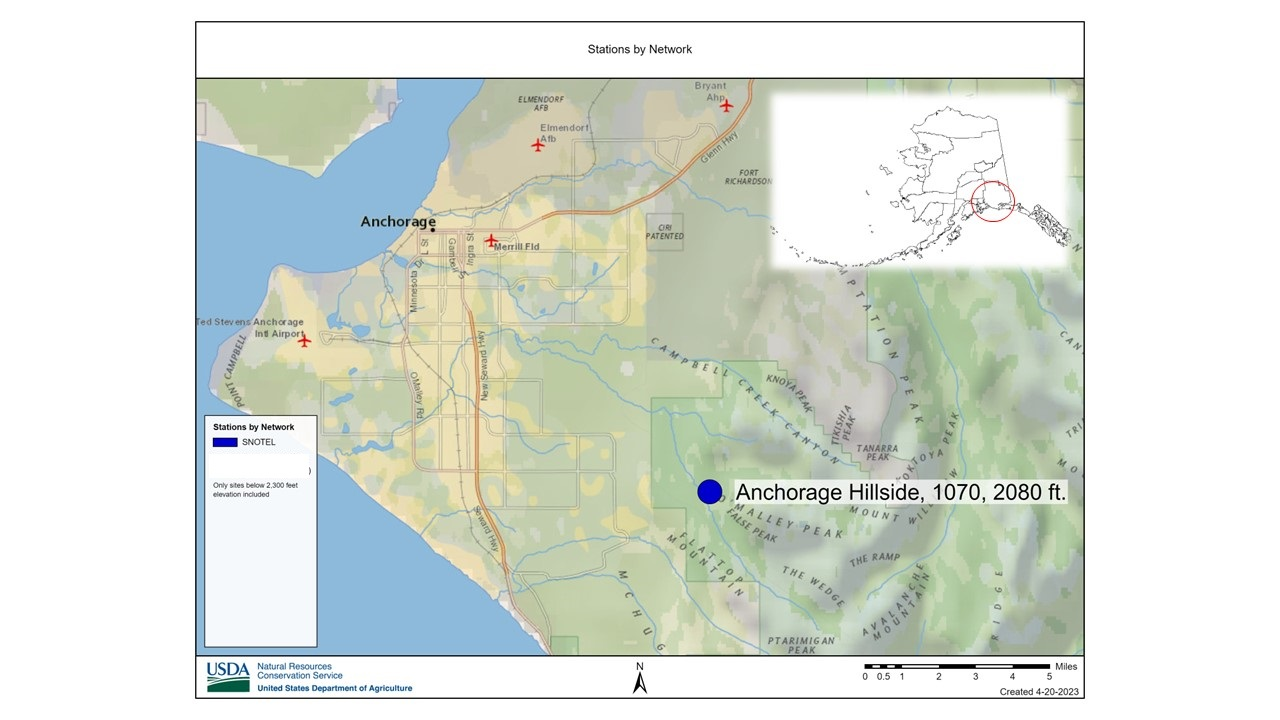

Anchorage has a subarctic climate, with long, cold winters and mild summers. The city experiences heavy snowfall during the winter months, making it ideal to explore snowfall changes. Additionally, Anchorage is backed to the East by the Chugach mountain range and faces a coastline with the gauge itself located closer to the hills than the coast. 


### Data Description
The data to be utilized is from the USDA. This dataset has a period of record of daily values from 2005-2023, the entirety of which will be analyzed. This data comes from a single gauge (#SNOTEL 1070) located in Anchorage Hillside, Alaska. This dataset includes year and snow water equivalent in inches measured daily instantesouly at the beginning of the day. 

URL: https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customGroupByMonthReport/daily/1070:AK:SNTL%7Cid=%22%22%7Cname/POR_BEGIN,POR_END/WTEQ::value 

### Methods and Results

In [2]:
#Parameters 
infile_name='WTEQ__value.txt'
fig_title='SWE'
monthlist=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#load and wrangle data types
data = pd.read_csv(infile_name, comment="#", delimiter =",", na_values=["Ice", "Bkw"], dtype={"Water Year": float})
data[['Water Year', 'Day']] = data[['Water Year', 'Day']].apply(pd.to_numeric, errors='coerce')
data=data[1:]

# Drop rows with missing values in 'Water Year' column
data.dropna(subset=['Water Year'], inplace=True)

# Drop rows with missing values in 'Day' column
data.dropna(subset=['Day'], inplace=True)

# Initialize an empty DataFrame to fill with wrangled data 
bigdata = pd.DataFrame()

#Fill the empty data frame using concatanation to list year after year of data
for i, month in enumerate(monthlist):
    datamonth=data[['Water Year','Day',month]].copy()
    datamonth['Month']=i+1
    datamonth['Snow']=datamonth[month]
    datamonth.drop(columns={month},inplace=True)
    try: 
        bigdata=pd.concat([bigdata,datamonth])
    except: 
        bigdata=datamonth
bigdata.rename(columns={'Day':'day','Month':'month'},inplace=True)  

# Create a new column "cal year" in the dataframe
bigdata['year'] = np.where(bigdata['month'] >= 10, bigdata['Water Year'] - 1, bigdata['Water Year'])

#Wrangle year data type 
bigdata['year']=bigdata['year'].astype('int64')

# Create a datetime column
bigdata['date'] = pd.to_datetime(bigdata[['year', 'month', 'day']], errors='coerce')

#Wrangle snow data type 
bigdata['Snow']=bigdata['Snow'].astype('float64')

# Set the 'date' column as the index
bigdata.set_index('date', inplace=True)

#Add column for cal day
bigdata['DOWY']=bigdata.index.dayofyear+92

#Adjusting Oct Nov DOWY
bigdata.loc[bigdata['month']>=10,'DOWY']=bigdata.loc[bigdata['month']>=10,'DOWY']-365

# Drop the 'Month', and 'Day' columns
bigdata.drop(columns=['month','day','year'], inplace=True)

#Trim to full water years, Identify the start and end dates of the data set
start_date = bigdata.index.min()
end_date = bigdata.index.max()

# Define the start and end dates of the full water year cycles
if start_date.month < 10:
    start_date = start_date.replace(year=start_date.year - 1, month=10, day=1)
else:
    start_date = start_date.replace(month=10, day=1)
if end_date.month < 10:
    end_date = end_date.replace(month=9, day=30)
else:
    end_date = end_date.replace(year=end_date.year + 1, month=9, day=30)

# Trim the data to the full water years
bigdata = bigdata[(bigdata.index >= start_date) & (bigdata.index <= end_date)]

Text(0.5, 1.0, 'SWE Magnitude Over Time')

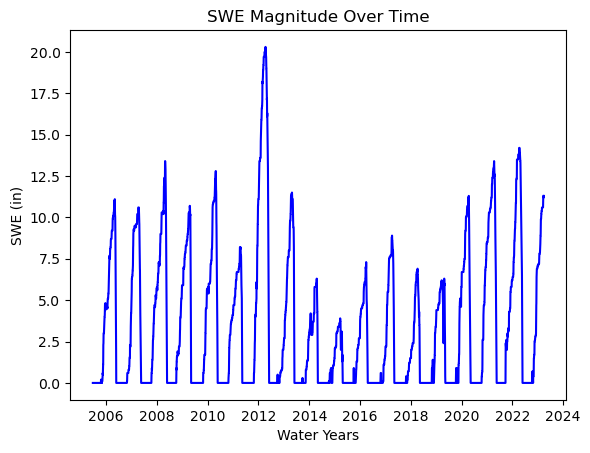

In [3]:
#Create a plot of the trimmed data 
fig, ax = plt.subplots()
pd.options.mode.chained_assignment = None
bigdata.sort_index(inplace=True)
ax.plot(bigdata['Snow'],'b-', label ='SWE') 
ax.set_ylabel('SWE (in)') 
ax.set_xlabel('Water Years')
ax.set_title('SWE Magnitude Over Time')


In [11]:
# Set the 'date' column as the index
bigdatadowy=bigdata.set_index('DOWY')
DOWYsnowpeak=bigdatadowy.groupby('Water Year').idxmax()
snowpeak=bigdatadowy.groupby('Water Year').max()

Text(0.5, 1.0, 'SWE')

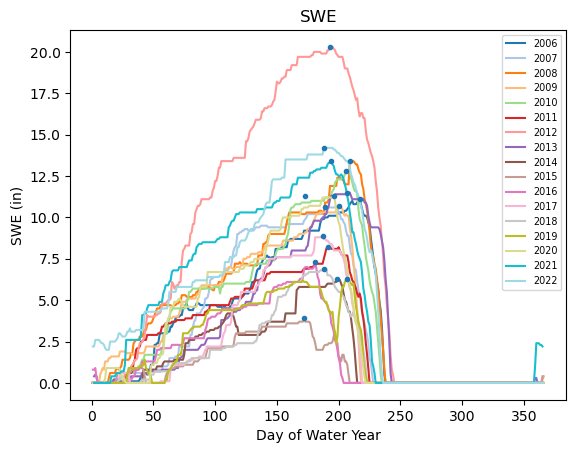

In [31]:
#Create the figure and sort dates 
fig, ax = plt.subplots()
bigdata.sort_index(inplace=True)
# Define a list of 17 colors using the built-in 'tab20' colormap in matplotlib
colors = plt.cm.tab20(np.linspace(0, 1, 17))
#Assign a different color to each of the 17 different years 
for i in range (2006,2023):
    ax.plot(bigdata.loc[bigdata['Water Year']==i,'DOWY'],
            bigdata.loc[bigdata['Water Year']==i,'Snow'],  # x = dataframe index (date), y = precip in mm
            '-', label =i,color=colors[i-2006]) 
# create a boolean mask to filter out the outlier
mask = (DOWYsnowpeak <= 250)
# plot the data points that do not have the outlier value using the color scheme 
ax.plot(DOWYsnowpeak[mask], snowpeak[mask], '.')
ax.set_ylabel('SWE (in)') 
ax.set_xlabel('Day of Water Year')
ax.legend(fontsize='x-small')
ax.set_title(fig_title)


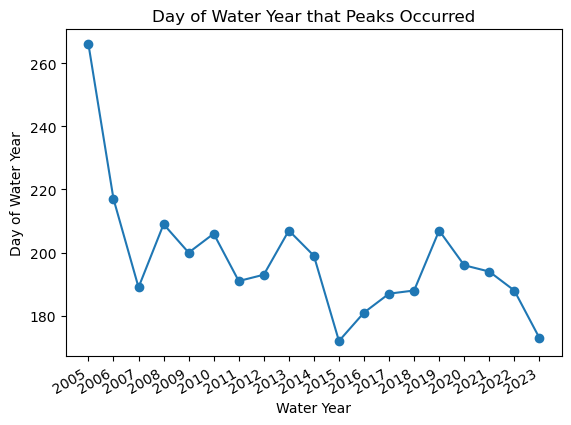

In [37]:
# Create a plot of water year vs. snow value
fig, ax = plt.subplots()
ax.plot(DOWYsnowpeak.index, DOWYsnowpeak['Snow'], marker='o', linestyle='-')
ax.set_xlabel('Water Year')
ax.set_xticks(DOWYsnowpeak.index)
ax.set_ylabel('Day of Water Year')
ax.set_title('Day of Water Year that Peaks Occurred')
fig.autofmt_xdate()
plt.show()

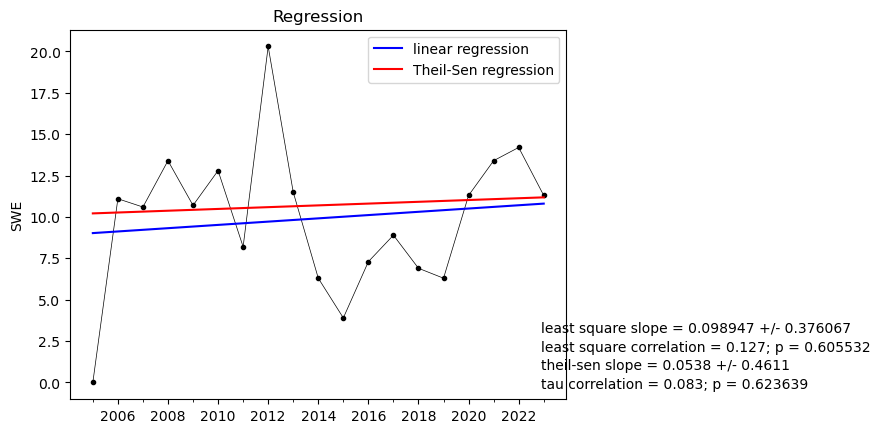

In [35]:
#Magnitude regression using two approaches (linear and Theil-Sen) 
def regressplot(timeseries,dataseries, y_label):

    #parametric linear regression 
    lsqcoeff = stats.linregress(timeseries,dataseries)
    
    #non-parametric regression (not sensitive to outliers, assessing median slope)
    sencoeff = stats.theilslopes(dataseries,timeseries, 0.95)
    
    #non-parametric correlation
    tau = stats.kendalltau(timeseries,dataseries)

    #plot
    fig, ax = plt.subplots()
    ax.plot(timeseries.T, dataseries.T, color='black', linestyle='-', linewidth=0.5, marker='.')
    #add parametric line
    ax.plot(timeseries, lsqcoeff.intercept + lsqcoeff.slope *
            timeseries, 'b-', label='linear regression')
    #add non-parametric line
    ax.plot(timeseries, sencoeff.intercept + sencoeff.slope *
               timeseries, 'r-', label='Theil-Sen regression')

    #annotation
    xx = ax.get_xlim()
    yy = ax.get_ylim()

    #show least squares slope and correlation on graph
    ax.annotate(f'least square slope = {lsqcoeff.slope:.6f} +/- {2*lsqcoeff.stderr:.6f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.18*(yy[1]-yy[0])),
                horizontalalignment='left')
    ax.annotate(f'least square correlation = {lsqcoeff.rvalue:.3f}; p = {lsqcoeff.pvalue:.6f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.13*(yy[1]-yy[0])),
                horizontalalignment='left')

    #show non parametric slope and correlation on graph
    ax.annotate(f'theil-sen slope = {sencoeff.slope:.4f} +/- {0.5*(sencoeff.high_slope - sencoeff.low_slope):.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.08*(yy[1]-yy[0])),
                    horizontalalignment='left')
    ax.annotate(f'tau correlation = {tau.correlation:.3f}; p = {tau.pvalue:.6f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.03*(yy[1]-yy[0])),
                    horizontalalignment='left')
    
    #finish with graph pieces
    ax.set_title('Regression')
    ax.set_ylabel(y_label)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    plt.show()
    
regressplot(snowpeak.index,snowpeak.values.T,'SWE')

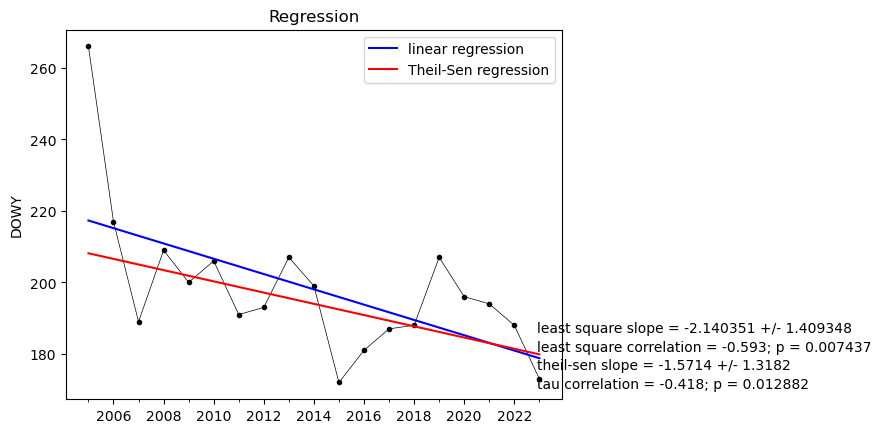

In [36]:
#Timing regression plot using previously defined function
regressplot(DOWYsnowpeak.index,DOWYsnowpeak['Snow'],'DOWY')

### Discussion 
* In statistics, the correlation coefficient (r) is a measure of the strength and direction of the linear relationship between two variables. The p-value associated with the correlation coefficient measures the probability of observing a correlation as strong or stronger than the one calculated, assuming that there is no true correlation between the variables.

* A high r value indicates a strong linear relationship between the two variables. If the p-value associated with the correlation coefficient is low (less than 0.05), it indicates that the observed correlation is statistically significant, meaning that it is unlikely to have occurred by chance.

* A high r value with a low p-value indicates a strong and statistically significant linear relationship between the two variables. This means that the correlation observed is unlikely to have occurred by chance and is most likely due to a true relationship between the variables.
    + Overall, magnitude of SWE did not experience siginificant changes (a low R value with a high P value). 
        - Timing of SWE did experience signigicant changes (a high r value with a low p value). It can be observed that as time continues, the regression shows the timing of peak SWE is occurring earlier in each water year as time goes on. 
        
* This is an important observation as impacts of global warming is already being seen (the artic is more senstive than lower latitiudes). People in Anchorage may experience risks due to snow such as avalanches if snow fall occurs sooner than what has been lived through in previous years. Additionally, ecosystems may not be adjusted to sooner snow melting (a frozen ground causes water to have difficulty infilitrating and can lead to more runoff than usual). Overall large water budget implications are present through transpiration and infiltration specifically. 

* If climate continues to warm, the timing of snow melt may continue to come sooner, and the magnitude of the snowpack may be unable to reach peaks seen previously.  

* This study would be improved by taking into account more than just one SNOTEL gauge, this would increase spatial considerations and limit singular gauge error. 